In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

In [3]:
mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

In [4]:
batch_size = 128
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [5]:
%matplotlib inline
from genereateTriplets import TripletMNIST


In [6]:
triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)


/home/jovyan/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/jovyan/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/jovyan/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/jovyan/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [8]:
from models import EncoderNet, TripletNet
from loss import TripletLoss

In [9]:
encoder = EncoderNet()
model = TripletNet(encoder)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TripletNet(
  (encoder_net): EncoderNet(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)

In [10]:
loss_fn = TripletLoss(margin=1)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [11]:
from train import fit
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/jovyan/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/60000 (0%)]	Loss: 0.999272
Train: [12800/60000 (21%)]	Loss: 0.284835
Train: [25600/60000 (43%)]	Loss: 0.152257
Train: [38400/60000 (64%)]	Loss: 0.100127
Train: [51200/60000 (85%)]	Loss: 0.080246
Epoch: 1/20. Train set: Average loss: 0.1434
Epoch: 1/20. Validation set: Average loss: 0.0570
Train: [0/60000 (0%)]	Loss: 0.043643
Train: [12800/60000 (21%)]	Loss: 0.054567
Train: [25600/60000 (43%)]	Loss: 0.055891
Train: [38400/60000 (64%)]	Loss: 0.043626
Train: [51200/60000 (85%)]	Loss: 0.046557
Epoch: 2/20. Train set: Average loss: 0.0485
Epoch: 2/20. Validation set: Average loss: 0.0444
Train: [0/60000 (0%)]	Loss: 0.036648
Train: [12800/60000 (21%)]	Loss: 0.038591
Train: [25600/60000 (43%)]	Loss: 0.029807
Train: [38400/60000 (64%)]	Loss: 0.034193
Train: [51200/60000 (85%)]	Loss: 0.027277
Epoch: 3/20. Train set: Average loss: 0.0315
Epoch: 3/20. Validation set: Average loss: 0.0419
Train: [0/60000 (0%)]	Loss: 0.022572
Train: [12800/60000 (21%)]	Loss: 0.028722
Train: [25600/60000 (

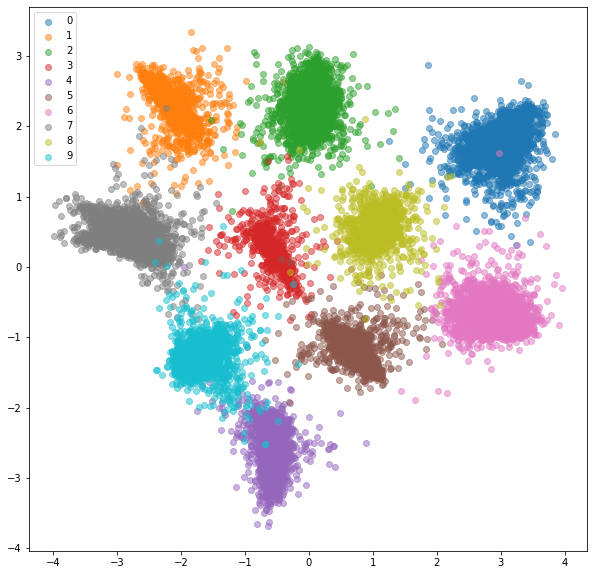

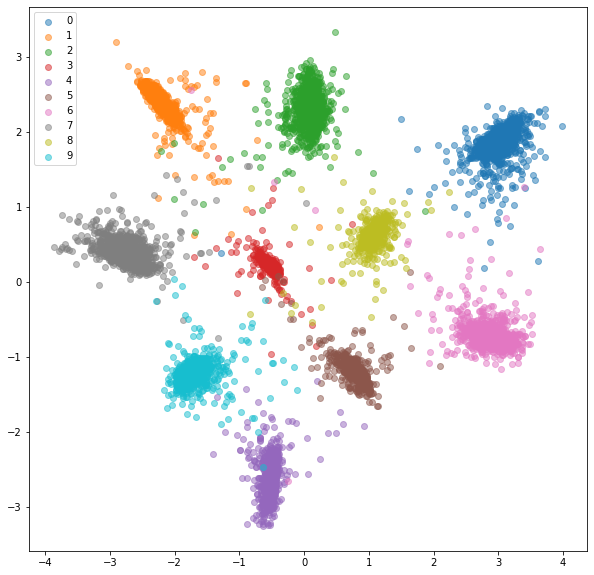

In [12]:
from plotExtract import plot_features, extract_features

train_features, train_labels = extract_features(train_loader, model)
plot_features(train_features, train_labels)
val_features, val_labels = extract_features(test_loader, model)
plot_features(val_features, val_labels)

In [19]:
torch.save(encoder.state_dict(), "./saved_models/enc_save.pth")
torch.save(model.state_dict(), "./saved_models/trip_save.pth")

In [20]:
encoder.state_dict()

OrderedDict([('convnet.0.weight',
              tensor([[[[-1.4991e-01,  2.2474e-01, -1.6612e-01, -6.7704e-02,  4.0421e-02],
                        [-1.0791e-01,  1.7084e-02, -2.2061e-01, -1.0694e-02,  1.5125e-01],
                        [ 3.0399e-02,  2.1704e-01, -9.9258e-02,  5.1195e-02,  9.5403e-02],
                        [-4.8468e-02,  1.9224e-01, -1.4021e-01, -1.4858e-01, -4.4586e-02],
                        [-1.3481e-02, -5.0266e-03, -1.8383e-01, -9.0729e-02,  6.8785e-02]]],
              
              
                      [[[-1.6379e-01, -2.8118e-02,  1.7638e-01, -1.5966e-01, -1.6324e-01],
                        [-1.4776e-01,  8.7648e-02,  5.9369e-02,  1.5494e-01, -2.9058e-03],
                        [-1.5199e-01, -1.5855e-01,  2.0653e-01, -1.7927e-01,  3.2975e-02],
                        [-1.2509e-01,  1.6234e-01,  1.3010e-01,  1.0019e-01, -7.6486e-02],
                        [ 1.4408e-01,  2.1836e-02, -3.3336e-02, -9.3860e-03, -2.2826e-01]]],
              
       